This is my first attempt at an OpenAI Gym environment. I am using REINFORCE with a baseline to learn a policy for the CartPole environment.

In [4]:
!pip install jax jaxlib

  Using cached jax-0.2.10.tar.gz (589 kB)
     |████████████████████████████████| 35.7 MB 25.6 MB/s eta 0:00:01    |████████████▌                   | 14.0 MB 7.7 MB/s eta 0:00:03     |█████████████▎                  | 14.8 MB 7.7 MB/s eta 0:00:03
  Created wheel for jax: filename=jax-0.2.10-py3-none-any.whl size=679776 sha256=e9c28e6d8250b2c9b5c961bd78eedad98905f51f72cd6dfd53b0e83e92c1e30f
  Stored in directory: /root/.cache/pip/wheels/2f/a6/d2/2a2675d03a81e7a2ef19b5bacec9c5fe8718a3f8caf941153a
Successfully built jax


In [ ]:
!pip install gym

In [5]:
import random

random.seed(0)

In [6]:
# We need 4 inputs and 2 softmax outputs for our policy network.

import jax.numpy as jnp
import jax.tree_util as tree_util
from jax import grad, jit, vmap
from jax import random as jrandom

from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, Softmax, Tanh

policy_init_fun, policy_net = stax.serial(Dense(256), Relu,
                                          Dense(2), Softmax)

baseline_init_fun, baseline_net = stax.serial(Dense(256), Relu,
                                              Dense(128),
                                              Dense(1))

Update rule for REINFORCE:

$\theta \leftarrow \theta + \alpha G_t \nabla \ln \pi(A_t \mid S_t, \theta)$

In [7]:
def select_action(policy_params, state):
    """
    Select an action according to a sample from the policy distribution.
    """
    
    # Select an action.
    policy_dist = policy_net(policy_params, jnp.array(state))
    action = random.choices([0, 1], weights=policy_dist)[0]
    
    return action

In [8]:
def value_estimate(baseline_params, state):
    """
    Produce a value estimate from the baseline network.
    """
    
    return baseline_net(baseline_params, jnp.array(state))[0]

In [15]:
policy_step_size = 1e-3
baseline_step_size = 3e-2 # This should be greater than policy_step_size.
consecutive_solutions_required = 3 # How many times should we have to solve the task in a row to stop training?

from jax.experimental.optimizers import adam

policy_opt_init, policy_opt_update, policy_opt_get_params = adam(policy_step_size)
baseline_opt_init, baseline_opt_update, baseline_opt_get_params = adam(baseline_step_size)

In [16]:
import gym

# Initialize the environment.
env = gym.make("CartPole-v1")
observation = env.reset()

# Initialize parameters.
policy_output_shape, policy_params = policy_init_fun(jrandom.PRNGKey(0), (1, 4))
baseline_output_shape, baseline_params = baseline_init_fun(jrandom.PRNGKey(0), (1, 4))

# Initialize optimizers.
policy_opt_state = policy_opt_init(policy_params)
baseline_opt_state = baseline_opt_init(baseline_params)

# This accumulator speeds up the parameter update computation.
total_reward = 0
# This is a list of tuples containing (state, action, reward).
episode_SARs = []

# Used for plotting.
total_rewards = []

consecutive_solutions = 0
episode = 1
print(f"Training until reward threshold {env.spec.reward_threshold} is attained {consecutive_solutions_required} times in a row.")
while True:
    action = select_action(policy_params, observation)
    previous_observation = observation
    observation, reward, done, info = env.step(action)
    
    # Update episode training data.
    total_reward += reward
    episode_SARs.append((previous_observation, action, reward))
    
    if done:
        total_rewards.append(total_reward)
        print(f"Episode {episode} reward achieved: {int(total_reward)}.")
        
        if total_reward >= env.spec.reward_threshold:
            consecutive_solutions += 1
            if consecutive_solutions == consecutive_solutions_required:
                # Training complete.
                print("Task solved!")
                break
        else:
            consecutive_solutions = 0
        
        # Reset the state to initial conditions.
        observation = env.reset()
        
        # Update the parameters.
        value_estimates = [value_estimate(baseline_params, state) for state, _, _ in episode_SARs]
        
        def policy_loss(policy_params, value_estimates, total_reward):
            loss = 0
            i = 0
            for state, action, reward in episode_SARs:
                value_error = total_reward - value_estimates[i]
                # Increase the loss.
                loss -= value_error * jnp.log(policy_net(policy_params, state)[action])
                # Update the return for the next step.
                total_reward -= reward
                i += 1
            
            return loss
        
        def baseline_loss(baseline_params, value_estimates, total_reward):
            loss = 0
            i = 0
            for state, action, reward in episode_SARs:
                value_error = total_reward - value_estimates[i]
                # Increase the loss.
                loss -= value_error * value_estimate(baseline_params, state)
                # Update the return for the next step.
                total_reward -= reward
                i += 1
            
            return loss
                
        policy_grad = grad(policy_loss)(policy_params, value_estimates, total_reward)
        baseline_grad = grad(baseline_loss)(baseline_params, value_estimates, total_reward)
        
        policy_opt_state = policy_opt_update(episode, policy_grad, policy_opt_state)
        baseline_opt_state = baseline_opt_update(episode, baseline_grad, baseline_opt_state)
        
        # Grab the updated parameters.
        policy_params = policy_opt_get_params(policy_opt_state)
        baseline_params = baseline_opt_get_params(baseline_opt_state)
        
        episode_SARs = []
        episode += 1
        total_reward = 0

Training until reward threshold 475.0 is attained 3 times in a row.
Episode 1 reward achieved: 12.
Episode 2 reward achieved: 13.
Episode 3 reward achieved: 22.
Episode 4 reward achieved: 12.
Episode 5 reward achieved: 16.
Episode 6 reward achieved: 40.
Episode 7 reward achieved: 27.
Episode 8 reward achieved: 8.
Episode 9 reward achieved: 26.
Episode 10 reward achieved: 31.
Episode 11 reward achieved: 12.
Episode 12 reward achieved: 19.
Episode 13 reward achieved: 34.
Episode 14 reward achieved: 11.
Episode 15 reward achieved: 20.
Episode 16 reward achieved: 25.
Episode 17 reward achieved: 11.
Episode 18 reward achieved: 13.
Episode 19 reward achieved: 18.
Episode 20 reward achieved: 22.
Episode 21 reward achieved: 10.
Episode 22 reward achieved: 24.
Episode 23 reward achieved: 17.
Episode 24 reward achieved: 37.
Episode 25 reward achieved: 44.
Episode 26 reward achieved: 12.
Episode 27 reward achieved: 13.
Episode 28 reward achieved: 10.
Episode 29 reward achieved: 17.
Episode 30 rew

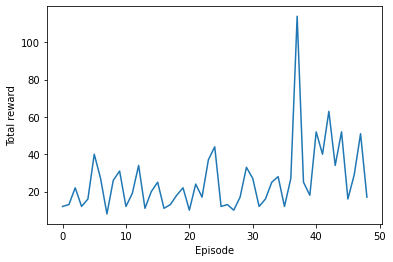

In [17]:
from matplotlib import pyplot as plt

plt.plot(total_rewards)
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.show()

In [18]:
!apt-get install python-opengl -y
!pip install pyvirtualdisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  freeglut3 libglu1-mesa
Suggested packages:
  python-tk python-numpy libgle3
The following NEW packages will be installed:
  freeglut3 libglu1-mesa python-opengl
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 738 kB of archives.
After this operation, 6207 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 freeglut3 amd64 2.8.1-3 [73.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libglu1-mesa amd64 9.0.0-2.1build1 [168 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 738 kB in 1s (537 kB/s)    
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package freeglut3:amd64.
(Reading database ... 111776 files and directories currentl

In [19]:
from pyvirtualdisplay import Display
import os

display = Display(visible=0, size=(1400, 900))
display.start()
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display._obj._screen)

Final reward: 44.0.


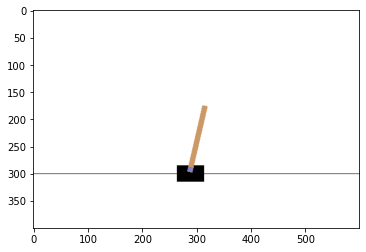

In [27]:
from matplotlib import animation, rc

fig = plt.figure()

frame = []

total_reward = 0
observation = env.reset()

while True:
    action = select_action(policy_params, observation)
    observation, reward, done, info = env.step(action)
    
    total_reward += reward
    
    img = plt.imshow(env.render("rgb_array"))
    frame.append([img])
    if done:
        break

anim = animation.ArtistAnimation(fig, frame, interval=100, repeat_delay=1000, blit=True)
rc("animation", html="jshtml")

print(f"Final reward: {total_reward}.")

anim